In [21]:
# Cell 1: Import required modules and load environment variables
import import_ipynb
import load_env
from load_env import *

# Import agent toolkit and initialize the CDP agent kit wrapper
from cdp_langchain.agent_toolkits import CdpToolkit
from cdp_langchain.utils import CdpAgentkitWrapper

cdp = CdpAgentkitWrapper()
toolkit = CdpToolkit.from_cdp_agentkit_wrapper(cdp)
tools_blockchain = toolkit.get_tools()

# Import LLM and create an instance using the Google GenAI model "gemini-2.0-flash"
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

# Import LangGraph’s helper to create react agents
from langgraph.prebuilt import create_react_agent


In [13]:
# Cell 2: Create our three agents

# Create the blockchain agent using the blockchain toolkit.
blockchain_agent = create_react_agent(llm, tools=tools_blockchain)

# For Twitter, use the ArcadeToolManager to load the X toolkit (assumes ARCADE_API_KEY is defined in the environment).
from langchain_arcade import ArcadeToolManager
tool_manager = ArcadeToolManager(api_key=ARCADE_API_KEY)
tools_twitter = tool_manager.get_tools(toolkits=["X"])
twitter_agent = create_react_agent(llm, tools=tools_twitter)

# Create the assistant agent.
# This agent’s sole work is to review the full conversation state and generate a confirmation or general query response.
# It no longer requires external internet access.
assistant_agent_prompt = (
    "You are an assistant agent whose job is to analyze the entire conversation state and, if a confirmation is needed, "
    "generate a concise confirmation message starting with 'Yes, please'. Otherwise, generate a helpful response to clarify "
    "or resolve any ambiguity."
)
assistant_agent = create_react_agent(llm, tools=[])  # No extra tools are needed.


In [14]:
# Cell 3: Define the supervisor's system prompt with explicit message naming and an example flow.
# The team now includes the assistant_agent.
members = ["blockchain_agent", "twitter_agent", "assistant_agent"]
options = members + ["FINISH"]

AGENT_CAPABILITIES = f"""
## Blockchain Agent Capabilities
- Deploy smart contracts (ERC20/ERC721)
- Manage crypto assets (ETH/USDC/NFT transfers)
- DeFi interactions (Morpho vault deposits/withdrawals)
- Price oracle queries (Pyth Network)
- Handle testnet faucet requests

## Twitter Agent Capabilities
- Post tweets (requires authentication)
- Search recent tweets by keywords/username
- Lookup tweet details by ID
- Delete existing tweets
- User profile lookups

## Assistant Agent Capabilities
- Review the entire conversation state.
- Generate confirmation messages or clarifying responses when needed
- Produce responses starting with "Yes, please" when a confirmation is required.

## Routing Rules
1. Use 'twitter_agent' for any request containing: tweet, post, search, lookup, delete.
2. Use 'blockchain_agent' for: deploy, transfer, balance, deposit, withdraw, nft.
3. Use 'assistant_agent' to generate a confirmation or answer a general query when the supervisor is unsure.
4. FINISH after one complete operation unless the user requests multiple steps.
"""

system_prompt = f"""
You are a supervisor tasked with managing a conversation between the following workers: {members}. Their capabilities are: {AGENT_CAPABILITIES}.
Your job is to carefully review the entire conversation history and determine which worker should act next or whether the task is complete.

Important:

Message Source Distinction:
    The conversation history is structured so that the very first message is the original query from the human user.
    All subsequent messages are generated by AI agents.
    Only genuine human input (messages with name "User") is to be treated as confirmation.

Confirmation and Routing:
    If an action requires confirmation (for example, confirming that faucet ETH should be fetched or that a tweet should be posted) and no genuine user confirmation is present, route the query to the Assistant Agent.
    The Assistant Agent will then analyze the full conversation state and generate an appropriate confirmation message (e.g., "Yes, please fetch the price of ETH in USD." or "Yes, please post the tweet.").
    You are responsible for both routing the conversation and ensuring that confirmations come from the Assistant Agent.

Avoid Re-Routing:
    Once a confirmed action has been executed and a final result (e.g., the price of ETH or a posted tweet) is obtained, do not route the conversation back to the same agent.
    Instead, update the state with the result and, if no further action is needed, respond with FINISH.

Task Delegation:
    Delegate tasks only when additional work is required.
    If the current result fully addresses the request, instruct FINISH.

Example Flow for the Query "What is the price of ETH in USD and post it on Twitter?":

Step 1: User Query
    - The conversation begins with a single human message:
      User: "What is the price of ETH in USD and post it on Twitter?"

Step 2: Agent Response and Assistant-Generated Confirmation
    - The supervisor routes to the Blockchain Agent.
    - Blockchain Agent: "Sorry, I cannot post to Twitter. However, I can fetch the price of ETH in USD for you. Do you want me to do that?"
    - Since no genuine user confirmation is present, you (as the supervisor) route to the Assistant Agent.
    - Assistant Agent: "Yes, please fetch the price of ETH in USD."
    - Then, you route back to the Blockchain Agent.

Step 3: Blockchain Agent Executes the Task
    - Blockchain Agent (Follow-up): "The price of ETH is $2609.37."

Step 4: Routing to the Next Agent
    - The supervisor then routes to the Twitter Agent.
    - Twitter Agent: "I am sorry, I cannot get the price of ETH in USD. However, I can post a tweet to X(Twitter). Do you want to post a tweet?"
    - Again, if no genuine user confirmation is present, you route to the Assistant Agent.
    - Assistant Agent: "Yes, please post the tweet. The price of ETh is $2609.37"
    - Then, you route to the Twitter Agent to execute the tweet.

Step 5: Completion
    - Once the tweet is posted or an appropriate response is obtained, the supervisor updates the state and responds with FINISH.

Based on these rules and the example above, analyze the conversation history and respond with the next worker to act or with FINISH if the overall task is complete.
"""


In [15]:
# Cell 4: Define a pydantic model for the Router, the State type, and the supervisor_node function

from typing import Literal
from pydantic import BaseModel
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage

class Router(BaseModel):
    next: Literal["blockchain_agent", "twitter_agent", "assistant_agent", "FINISH"]

class State(MessagesState):
    next: str

def supervisor_node(state: State) -> Command[Literal["blockchain_agent", "twitter_agent", "__end__"]]:
    # Combine the system prompt with the conversation history
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    print(f"State in supervisor: {state}")
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response.next
    print(f"Routing to {goto}")
    if goto == "FINISH":
        goto = END
    return Command(goto=goto, update={"next": goto})


In [16]:
# Cell 5: Define nodes for the blockchain, twitter, and assistant agents.

def blockchain_node(state: State) -> Command[Literal["supervisor"]]:
    result = blockchain_agent.invoke(state)
    content = result["messages"][-1].content
    return Command(
        update={
            "messages": [HumanMessage(content=content, name="blockchain_agent")],
            "next": "supervisor"
        },
        goto="supervisor",
    )

def twitter_node(state: State) -> Command[Literal["supervisor"]]:
    result = twitter_agent.invoke(state)
    content = result["messages"][-1].content
    return Command(
        update={
            "messages": [HumanMessage(content=content, name="twitter_agent")],
            "next": "supervisor"
        },
        goto="supervisor",
    )

def assistant_node(state: State) -> Command[Literal["supervisor"]]:
    # Build a conversation context string from all messages.
    conversation_context = " ".join([msg.content for msg in state["messages"]])
    print(f"COnversation history {conversation_context}")
    prompt = (
        f"Given the full conversation context: '{conversation_context}', "
        "if a confirmation is needed for the current action (e.g., fetching ETH or posting a tweet), "
        "generate a concise confirmation message starting with 'Yes, please'. Otherwise, provide a clarifying response."
    )
    # IMPORTANT: Pass the prompt under the 'contents' key as required.
    # result = llm.invoke({"contents": [prompt]})
    result = llm.invoke(prompt)

    content = result.content

    print(f"Content generated {content}")
    return Command(
        update={
            "messages": [HumanMessage(content=content, name="assistant_agent")],
            "next": "supervisor"
        },
        goto="supervisor",
    )


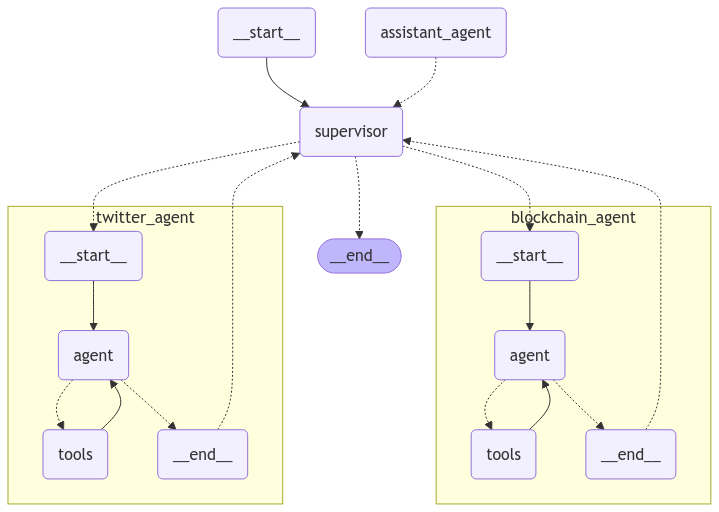

In [17]:
# Cell 6: Build the conversation graph using LangGraph's StateGraph

from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)
builder.add_node("supervisor", supervisor_node)
builder.add_node("blockchain_agent", blockchain_node)
builder.add_node("twitter_agent", twitter_node)
builder.add_node("assistant_agent", assistant_node)
builder.add_edge(START, "supervisor")

graph = builder.compile()

# Optionally, display the graph using mermaid visualization
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))


In [22]:
# Cell 7: Invoke the graph with a sample conversation

from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1", "user_id": "user@example.com"}}
initial_messages = [HumanMessage(content="Hi", name="User")]

result_state = graph.invoke({"messages": initial_messages}, config=config, stream_mode="values")

# Print the last few messages for clarity
for m in result_state["messages"][-4:]:
    m.pretty_print()


State in supervisor: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, name='User', id='383f20cc-a334-419c-ae48-67fb2ecdbea7')]}
Routing to assistant_agent
COnversation history Hi
Content generated Since "Hi" doesn't imply any action requiring confirmation, a clarifying response is needed.

**Clarifying Response:** What can I help you with?
State in supervisor: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, name='User', id='383f20cc-a334-419c-ae48-67fb2ecdbea7'), HumanMessage(content='Since "Hi" doesn\'t imply any action requiring confirmation, a clarifying response is needed.\n\n**Clarifying Response:** What can I help you with?', additional_kwargs={}, response_metadata={}, name='assistant_agent', id='7b05a9fe-ba32-4629-a032-813516413214')], 'next': 'supervisor'}
Routing to assistant_agent
COnversation history Hi Since "Hi" doesn't imply any action requiring confirmation, a clarifying response is needed.

**Clari

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 Resource has been exhausted (e.g. check quota)..


ResourceExhausted: 429 Resource has been exhausted (e.g. check quota).

{'messages': [HumanMessage(content='Get some eth faucets on base-sepolia and post about it on twitter', additional_kwargs={}, response_metadata={}, name='User', id='f07037c6-43ea-4f5a-bc74-5edbcad1a2ae'), HumanMessage(content="I can get you some eth faucets on base-sepolia, but I can't post about it on Twitter. I don't have the functionality to post on social media. Would you like me to proceed with just getting the eth faucets on base-sepolia?", additional_kwargs={}, response_metadata={}, name='blockchain_agent', id='44a15260-e891-4989-9a00-49409c1a5ba4'), HumanMessage(content='Yes, please proceed with just getting the eth faucets on base-sepolia.', additional_kwargs={}, response_metadata={}, name='assistant_agent', id='437f11a1-7ee6-4bd7-86c6-70549889af05'), HumanMessage(content='I have requested ETH from the faucet on base-sepolia for you. You can view the transaction at https://sepolia.basescan.org/tx/0x0d813d63e1b823aa056791762f2b1b50fe6d32eaa6ad245666b91e3c2e4f22a9.', additional_